# Project 4 — Module 5: Statistical Inference
## Lesson 3: Probability Distributions

| | |
|---|---|
| **Author** | Jose Marcel Lopez Pino |
| **Framework** | CRISP-DM + LEAN |
| **Phase** | 3 — Data Preparation / Modeling |
| **Module** | 5 — Statistical Inference (Alkemy Bootcamp) |
| **Dataset** | Student Habits vs Academic Performance — Kaggle |
| **Date** | 2026-02 |

---

> **Executive Summary:**
> This notebook corresponds to Lesson 3 of Module 5 (Statistical Inference).
> Key variables are evaluated against theoretical probability distributions
> (Normal, Poisson, Binomial). Distribution choice is justified statistically,
> probabilities are calculated using scipy, and distributions are visualized
> with theoretical overlays. Results directly inform the statistical test
> selection in Lesson 6.

---

## Table of Contents

1. [CRISP-DM Phase 3 — Data Preparation / Modeling](#1-crisp-dm-phase-3--data-preparation--modeling)
2. [Load Processed Data](#2-load-processed-data)
3. [Distribution Framework — Decision Guide](#3-distribution-framework--decision-guide)
4. [Normal Distribution — sleep_hours](#4-normal-distribution--sleep_hours)
5. [Normal Distribution — exam_score](#5-normal-distribution--exam_score)
6. [Poisson Distribution — exercise_frequency](#6-poisson-distribution--exercise_frequency)
7. [Binomial Distribution — sedentary_flag](#7-binomial-distribution--sedentary_flag)
8. [Probability Calculations — Key Business Events](#8-probability-calculations--key-business-events)
9. [LEAN Filter — Waste Elimination Review](#9-lean-filter--waste-elimination-review)
10. [Decisions Log — Lesson 3](#10-decisions-log--lesson-3)

---
## 1. CRISP-DM Phase 3 — Data Preparation / Modeling

**Objective:** Identify which theoretical distributions best fit key variables.
Justify the choice statistically and calculate probabilities for business events.

**Lean Filter:** Only fit distributions for variables directly linked to the
research questions (RQ1–RQ5). Distribution fitting for non-hypothesis variables is waste.

> **Key question for this phase:**
> *Which theoretical distribution best represents each variable,
> and what does that imply for the hypothesis tests in Lesson 6?*

In [1]:
# ===== Environment Setup =====
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.stats import norm, poisson, binom

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Blues_d')

DATA_RAW        = Path('../data/raw')
DATA_PROCESSED  = Path('../data/processed')
REPORTS_FIGURES = Path('../reports/figures')
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

print('Environment ready.')

Environment ready.


---
## 2. Load Processed Data

In [2]:
# ===== Load Dataset =====
# Using raw data — cleaning will be minimal (dataset is already clean per Lesson 2)
CSV_FILE = DATA_RAW / 'student_habits_performance.csv'
df = pd.read_csv(CSV_FILE)

print(f'Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns')
df.head(3)

Dataset loaded: 1,000 rows x 16 columns


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3


---
## 3. Distribution Framework — Decision Guide

Before fitting, classify each variable using this decision framework:

| Variable Type | Possible Distributions | Decision Criterion |
|--------------|----------------------|-------------------|
| Continuous, symmetric | Normal | Histogram bell-shaped + Shapiro-Wilk p > 0.05 |
| Discrete, count of events | Poisson | Count data, mean ≈ variance |
| Discrete, binary outcomes | Binomial | Two outcomes (success/failure), fixed n trials |
| Continuous, skewed | Log-Normal / Gamma | Shapiro-Wilk p < 0.05 + right skew |

### Variable Assignment (from Lesson 1)

| Variable | Expected Distribution | Justification |
|----------|----------------------|---------------|
| `sleep_hours` | Normal | Continuous, biological variable — tends toward normality |
| `exam_score` | Normal | Continuous, aggregate measure — CLT applies |
| `exercise_frequency` | Poisson | Discrete count (days/week), non-negative integer |
| `sedentary_flag` (< 3 days) | Binomial | Binary outcome per student, fixed n |

> **Note:** Expected distributions from Lesson 1 will be verified empirically here.

---
## 4. Normal Distribution — sleep_hours

**Research Question:** RQ1 — Do students sleep fewer hours than the WHO benchmark (7h)?
**Hypothesis:** H1 — μ_sleep = 7 (one-sample t-test, left-tailed)
**Why Normal?** Sleep duration is a continuous biological variable.
By the CLT, averages of biological measurements tend toward normality.

In [3]:
# ===== Descriptive Statistics — sleep_hours =====
sleep = df['sleep_hours'].dropna()

mu_sleep  = sleep.mean()
std_sleep = sleep.std()
n_sleep   = len(sleep)

print('=== sleep_hours — Descriptive Statistics ===')
print(f'n     = {n_sleep:,}')
print(f'mean  = {mu_sleep:.4f} h')
print(f'std   = {std_sleep:.4f} h')
print(f'min   = {sleep.min():.2f} h')
print(f'max   = {sleep.max():.2f} h')
print(f'skew  = {sleep.skew():.4f}  (|skew| < 0.5 suggests normality)')
print(f'kurt  = {sleep.kurt():.4f}  (kurt ≈ 0 suggests normality)')

=== sleep_hours — Descriptive Statistics ===
n     = 1,000
mean  = 6.4701 h
std   = 1.2264 h
min   = 3.20 h
max   = 10.00 h
skew  = 0.0915  (|skew| < 0.5 suggests normality)
kurt  = -0.2143  (kurt ≈ 0 suggests normality)


In [4]:
# ===== Normality Test — Shapiro-Wilk =====
# Note: Shapiro-Wilk is sensitive for large n — interpret with histogram too
stat, p_shapiro = stats.shapiro(sleep.sample(min(500, len(sleep)), random_state=42))

print('=== Shapiro-Wilk Normality Test ===')
print(f'W statistic = {stat:.4f}')
print(f'p-value     = {p_shapiro:.4f}')
print()
if p_shapiro > 0.05:
    print('→ Fail to reject H₀: data is consistent with normality (p > 0.05)')
else:
    print('→ Reject H₀: data deviates from normality (p < 0.05)')
    print('→ However, with n > 200, t-test is robust to moderate non-normality (CLT)')

=== Shapiro-Wilk Normality Test ===
W statistic = 0.9957
p-value     = 0.1895

→ Fail to reject H₀: data is consistent with normality (p > 0.05)


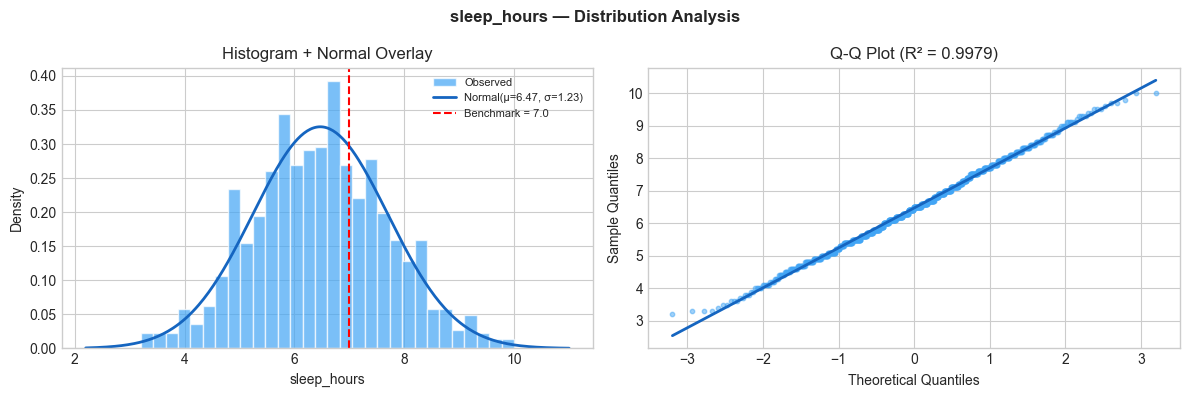

Figure saved: ..\reports\figures\lesson3_sleep_distribution.png


In [5]:
# ===== Plot — sleep_hours Distribution =====
def plot_normal_fit(data: pd.Series, var_name: str, benchmark: float = None,
                   figname: str = 'dist.png') -> None:
    """Plots histogram with normal distribution overlay and optional benchmark line.

    Args:
        data: Series of values to plot.
        var_name: Variable name for labels.
        benchmark: Optional vertical line (e.g. WHO threshold).
        figname: Output filename.

    Returns:
        None
    """
    mu, std = data.mean(), data.std()
    x = np.linspace(data.min() - 1, data.max() + 1, 300)
    y = norm.pdf(x, mu, std)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{var_name} — Distribution Analysis', fontsize=12, fontweight='bold')

    # Histogram + normal overlay
    axes[0].hist(data, bins=30, density=True, color='#42A5F5', alpha=0.7,
                 edgecolor='white', label='Observed')
    axes[0].plot(x, y, color='#1565C0', lw=2, label=f'Normal(μ={mu:.2f}, σ={std:.2f})')
    if benchmark:
        axes[0].axvline(benchmark, color='red', linestyle='--', lw=1.5,
                        label=f'Benchmark = {benchmark}')
    axes[0].set_xlabel(var_name)
    axes[0].set_ylabel('Density')
    axes[0].legend(fontsize=8)
    axes[0].set_title('Histogram + Normal Overlay')

    # Q-Q plot
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist='norm')
    axes[1].scatter(osm, osr, color='#42A5F5', alpha=0.5, s=10)
    axes[1].plot(osm, slope * np.array(osm) + intercept, color='#1565C0', lw=2)
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Sample Quantiles')
    axes[1].set_title(f'Q-Q Plot (R² = {r**2:.4f})')

    plt.tight_layout()
    output_path = REPORTS_FIGURES / figname
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Figure saved: {output_path}')


plot_normal_fit(sleep, 'sleep_hours', benchmark=7.0,
                figname='lesson3_sleep_distribution.png')

In [6]:
# ===== Probability Calculations — sleep_hours =====
# Using fitted Normal(mu, std) to calculate key probabilities

print('=== Probability Calculations — Normal(μ={:.2f}, σ={:.2f}) ==='.format(mu_sleep, std_sleep))
print()

# P(sleep < 7) — probability a random student sleeps less than WHO benchmark
p_sleep_lt_7 = norm.cdf(7, mu_sleep, std_sleep)
print(f'P(sleep < 7h)  = {p_sleep_lt_7:.4f}  ({p_sleep_lt_7*100:.1f}%)')

# P(sleep < 6) — severe sleep deprivation
p_sleep_lt_6 = norm.cdf(6, mu_sleep, std_sleep)
print(f'P(sleep < 6h)  = {p_sleep_lt_6:.4f}  ({p_sleep_lt_6*100:.1f}%)')

# P(sleep >= 8) — optimal sleep
p_sleep_ge_8 = 1 - norm.cdf(8, mu_sleep, std_sleep)
print(f'P(sleep >= 8h) = {p_sleep_ge_8:.4f}  ({p_sleep_ge_8*100:.1f}%)')

print()
print('=== Business Interpretation ===')
print(f'→ {p_sleep_lt_7*100:.1f}% of students are estimated to sleep below the WHO 7h benchmark')
print(f'→ {p_sleep_lt_6*100:.1f}% experience severe sleep deprivation (< 6h)')
print(f'→ Only {p_sleep_ge_8*100:.1f}% achieve optimal sleep (≥ 8h)')

=== Probability Calculations — Normal(μ=6.47, σ=1.23) ===

P(sleep < 7h)  = 0.6672  (66.7%)
P(sleep < 6h)  = 0.3507  (35.1%)
P(sleep >= 8h) = 0.1061  (10.6%)

=== Business Interpretation ===
→ 66.7% of students are estimated to sleep below the WHO 7h benchmark
→ 35.1% experience severe sleep deprivation (< 6h)
→ Only 10.6% achieve optimal sleep (≥ 8h)


---
## 5. Normal Distribution — exam_score

**Research Questions:** All RQs — exam_score is the dependent variable.
**Why Normal?** Exam scores are continuous aggregates. By the CLT,
the distribution of means will be normal regardless of the underlying distribution.

=== exam_score — Descriptive Statistics ===
n     = 1,000
mean  = 69.6015
std   = 16.8886
skew  = -0.1564
kurt  = -0.4199

Shapiro-Wilk: W=0.9857, p=0.0001


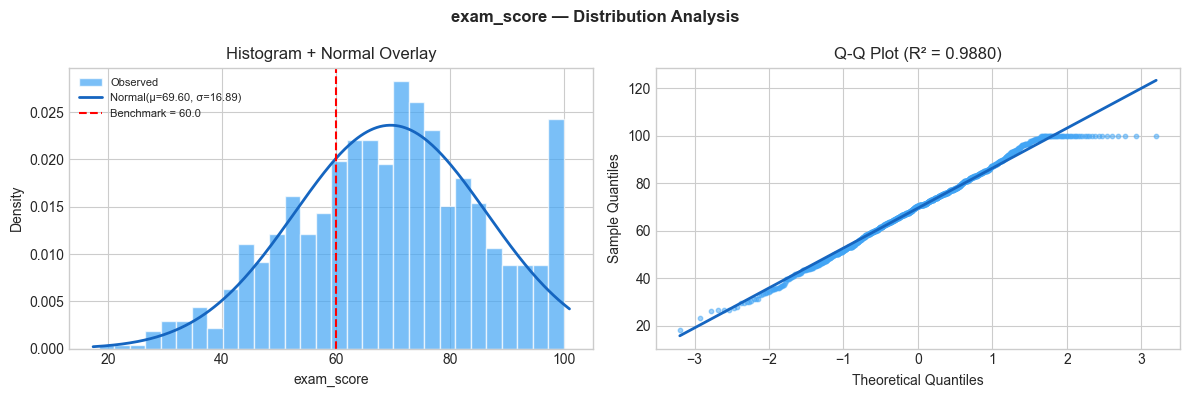

Figure saved: ..\reports\figures\lesson3_score_distribution.png


In [7]:
# ===== exam_score Distribution =====
score = df['exam_score'].dropna()

mu_score  = score.mean()
std_score = score.std()

print('=== exam_score — Descriptive Statistics ===')
print(f'n     = {len(score):,}')
print(f'mean  = {mu_score:.4f}')
print(f'std   = {std_score:.4f}')
print(f'skew  = {score.skew():.4f}')
print(f'kurt  = {score.kurt():.4f}')

stat_s, p_s = stats.shapiro(score.sample(min(500, len(score)), random_state=42))
print()
print(f'Shapiro-Wilk: W={stat_s:.4f}, p={p_s:.4f}')

plot_normal_fit(score, 'exam_score', benchmark=60.0,
                figname='lesson3_score_distribution.png')

In [8]:
# ===== Probability Calculations — exam_score =====
print('=== Probability Calculations — Normal(μ={:.2f}, σ={:.2f}) ==='.format(mu_score, std_score))
print()

p_fail    = norm.cdf(60, mu_score, std_score)
p_pass    = 1 - p_fail
p_excel   = 1 - norm.cdf(85, mu_score, std_score)
p_mid     = norm.cdf(75, mu_score, std_score) - norm.cdf(60, mu_score, std_score)

print(f'P(score < 60)       = {p_fail:.4f}  ({p_fail*100:.1f}%)  — academic risk')
print(f'P(score >= 60)      = {p_pass:.4f}  ({p_pass*100:.1f}%)  — passing')
print(f'P(score >= 85)      = {p_excel:.4f}  ({p_excel*100:.1f}%)  — excellent')
print(f'P(60 <= score < 75) = {p_mid:.4f}  ({p_mid*100:.1f}%)  — average range')

print()
print('=== Business Interpretation ===')
print(f'→ {p_fail*100:.1f}% of students are at academic risk (score < 60)')
print(f'→ {p_excel*100:.1f}% achieve excellent performance (score ≥ 85)')

=== Probability Calculations — Normal(μ=69.60, σ=16.89) ===

P(score < 60)       = 0.2848  (28.5%)  — academic risk
P(score >= 60)      = 0.7152  (71.5%)  — passing
P(score >= 85)      = 0.1809  (18.1%)  — excellent
P(60 <= score < 75) = 0.3405  (34.1%)  — average range

=== Business Interpretation ===
→ 28.5% of students are at academic risk (score < 60)
→ 18.1% achieve excellent performance (score ≥ 85)


---
## 6. Poisson Distribution — exercise_frequency

**Research Questions:** RQ2, RQ4
**Why Poisson?** `exercise_frequency` is a discrete count (days/week, 0–7).
Poisson models the number of occurrences of an event in a fixed interval.
Key assumption: mean ≈ variance.

In [9]:
# ===== exercise_frequency — Poisson Fit =====
exercise = df['exercise_frequency'].dropna()

lambda_ex = exercise.mean()
var_ex    = exercise.var()

print('=== exercise_frequency — Descriptive Statistics ===')
print(f'n        = {len(exercise):,}')
print(f'mean (λ) = {lambda_ex:.4f}')
print(f'variance = {var_ex:.4f}')
print(f'ratio var/mean = {var_ex/lambda_ex:.4f}  (≈1 supports Poisson)')
print()

# Goodness of fit — compare observed vs Poisson expected frequencies
observed_counts = exercise.value_counts().sort_index()
values = observed_counts.index
expected_probs = poisson.pmf(values, lambda_ex)
expected_counts = expected_probs * len(exercise)

comparison = pd.DataFrame({
    'Days/week': values,
    'Observed': observed_counts.values,
    'Expected (Poisson)': expected_counts.round(1)
})
print('=== Observed vs Expected (Poisson) ===')
print(comparison.to_string(index=False))

=== exercise_frequency — Descriptive Statistics ===
n        = 1,000
mean (λ) = 3.0420
variance = 4.1023
ratio var/mean = 1.3486  (≈1 supports Poisson)

=== Observed vs Expected (Poisson) ===
 Days/week  Observed  Expected (Poisson)
         0       144                47.7
         1       146               145.2
         2       122               220.9
         3       153               224.0
         4       134               170.3
         5       149               103.6
         6       152                52.5


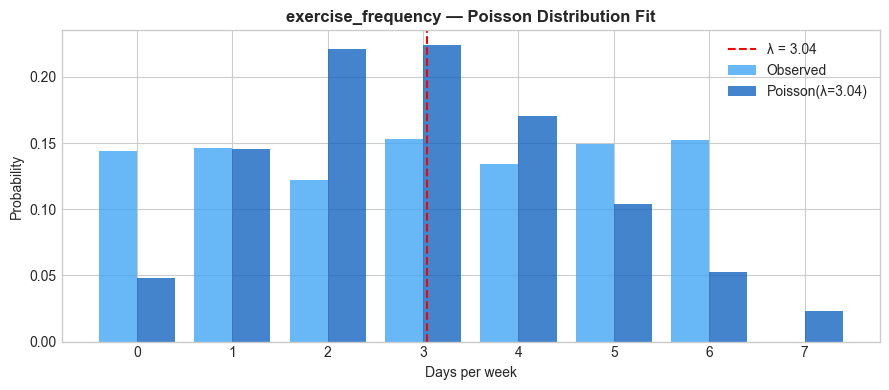

Figure saved: ..\reports\figures\lesson3_exercise_distribution.png


In [10]:
# ===== Plot — exercise_frequency =====
def plot_poisson_fit(data: pd.Series, lambda_: float, var_name: str,
                    figname: str = 'dist.png') -> None:
    """Plots bar chart with Poisson PMF overlay.

    Args:
        data: Discrete count data.
        lambda_: Estimated lambda (mean).
        var_name: Variable name for labels.
        figname: Output filename.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(9, 4))

    values = np.arange(0, data.max() + 2)
    obs_freq = data.value_counts(normalize=True).reindex(values, fill_value=0)
    poisson_pmf = poisson.pmf(values, lambda_)

    x = np.arange(len(values))
    width = 0.4
    ax.bar(x - width/2, obs_freq, width, label='Observed', color='#42A5F5', alpha=0.8)
    ax.bar(x + width/2, poisson_pmf, width, label=f'Poisson(λ={lambda_:.2f})',
           color='#1565C0', alpha=0.8)
    ax.axvline(lambda_, color='red', linestyle='--', lw=1.5, label=f'λ = {lambda_:.2f}')
    ax.set_xticks(x)
    ax.set_xticklabels(values)
    ax.set_xlabel('Days per week')
    ax.set_ylabel('Probability')
    ax.set_title(f'{var_name} — Poisson Distribution Fit', fontsize=12, fontweight='bold')
    ax.legend()
    plt.tight_layout()
    output_path = REPORTS_FIGURES / figname
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Figure saved: {output_path}')


plot_poisson_fit(exercise, lambda_ex, 'exercise_frequency',
                 figname='lesson3_exercise_distribution.png')

In [11]:
# ===== Probability Calculations — Poisson =====
print(f'=== Probability Calculations — Poisson(λ={lambda_ex:.2f}) ===')
print()

p_sedentary   = poisson.cdf(2, lambda_ex)       # P(exercise <= 2) — sedentary
p_active      = 1 - poisson.cdf(2, lambda_ex)   # P(exercise >= 3) — active
p_zero        = poisson.pmf(0, lambda_ex)        # P(no exercise at all)
p_daily       = poisson.pmf(7, lambda_ex)        # P(exercise every day)

print(f'P(exercise <= 2 days) — sedentary:   {p_sedentary:.4f}  ({p_sedentary*100:.1f}%)')
print(f'P(exercise >= 3 days) — active:      {p_active:.4f}  ({p_active*100:.1f}%)')
print(f'P(exercise = 0 days)  — no activity: {p_zero:.4f}  ({p_zero*100:.1f}%)')
print(f'P(exercise = 7 days)  — daily:       {p_daily:.4f}  ({p_daily*100:.1f}%)')
print()
print('=== Business Interpretation ===')
print(f'→ {p_sedentary*100:.1f}% of students lead sedentary lifestyles (< 3 days/week)')
print(f'→ {p_zero*100:.1f}% report zero physical activity')

=== Probability Calculations — Poisson(λ=3.04) ===

P(exercise <= 2 days) — sedentary:   0.4138  (41.4%)
P(exercise >= 3 days) — active:      0.5862  (58.6%)
P(exercise = 0 days)  — no activity: 0.0477  (4.8%)
P(exercise = 7 days)  — daily:       0.0228  (2.3%)

=== Business Interpretation ===
→ 41.4% of students lead sedentary lifestyles (< 3 days/week)
→ 4.8% report zero physical activity


---
## 7. Binomial Distribution — sedentary_flag

**Research Question:** RQ4 — H3: p_sedentary = 0.50
**Why Binomial?** Each student is either sedentary (< 3 days) or active (≥ 3 days).
Binary outcome across n independent trials = Binomial model.

**Parameters:**
- n = sample size
- p = estimated proportion of sedentary students from data

In [12]:
# ===== Binomial Fit — sedentary_flag =====
sedentary_flag = (df['exercise_frequency'] < 3).astype(int)

n_binom  = len(sedentary_flag)
p_hat    = sedentary_flag.mean()
p_null   = 0.50   # H3 null hypothesis value

print('=== sedentary_flag — Binomial Parameters ===')
print(f'n (sample size)       = {n_binom:,}')
print(f'p̂ (observed prop.)   = {p_hat:.4f}  ({p_hat*100:.1f}%)')
print(f'p₀ (H3 null value)   = {p_null:.2f}  ({p_null*100:.0f}%)')
print()

# Binomial probabilities under null hypothesis
p_exactly_half = binom.pmf(int(n_binom * p_null), n_binom, p_null)
p_observed_or_more = 1 - binom.cdf(int(n_binom * p_hat) - 1, n_binom, p_null)

print(f'P(X = {int(n_binom*p_null)}) under H₀:           {p_exactly_half:.6f}')
print(f'P(X >= {int(n_binom*p_hat)}) under H₀ (p-value approx): {p_observed_or_more:.6f}')
print()
print('=== Business Interpretation ===')
if p_hat > p_null:
    print(f'→ Observed sedentarism ({p_hat*100:.1f}%) exceeds the 50% benchmark')
    print('→ Preliminary evidence supports H3 — verify with z-test in Lesson 6')
else:
    print(f'→ Observed sedentarism ({p_hat*100:.1f}%) does not exceed the 50% benchmark')

=== sedentary_flag — Binomial Parameters ===
n (sample size)       = 1,000
p̂ (observed prop.)   = 0.4120  (41.2%)
p₀ (H3 null value)   = 0.50  (50%)

P(X = 500) under H₀:           0.025225
P(X >= 412) under H₀ (p-value approx): 1.000000

=== Business Interpretation ===
→ Observed sedentarism (41.2%) does not exceed the 50% benchmark


C:\Users\carol\AppData\Local\Temp\ipykernel_22276\220461807.py:34: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\carol\AppData\Local\Temp\ipykernel_22276\220461807.py:36: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig(output_path, dpi=150, bbox_inches='tight')
c:\Users\carol\OneDrive\Documentos\Jose\SENCE\Bootcamp\Bootcamp_Data_Science_Portfolio\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


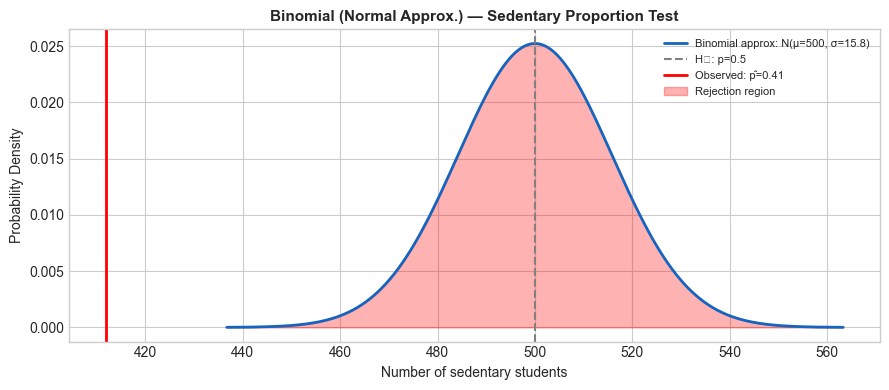

Figure saved: ..\reports\figures\lesson3_binomial_sedentary.png


In [13]:
# ===== Plot — Binomial Distribution =====
def plot_binomial(n: int, p_hat: float, p_null: float,
                  figname: str = 'dist.png') -> None:
    """Plots Binomial PMF under null hypothesis with observed value marked.

    Args:
        n: Sample size.
        p_hat: Observed proportion.
        p_null: Null hypothesis proportion.
        figname: Output filename.

    Returns:
        None
    """
    # Use normal approximation for large n (CLT)
    mu_b  = n * p_null
    std_b = np.sqrt(n * p_null * (1 - p_null))
    x = np.linspace(mu_b - 4*std_b, mu_b + 4*std_b, 300)
    y = norm.pdf(x, mu_b, std_b)

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(x, y, color='#1565C0', lw=2,
            label=f'Binomial approx: N(μ={mu_b:.0f}, σ={std_b:.1f})')
    ax.axvline(n * p_null, color='gray', linestyle='--', lw=1.5, label=f'H₀: p={p_null}')
    ax.axvline(n * p_hat, color='red', linestyle='-', lw=2,
               label=f'Observed: p̂={p_hat:.2f}')
    ax.fill_between(x, y, where=(x >= n * p_hat), alpha=0.3, color='red',
                    label='Rejection region')
    ax.set_xlabel('Number of sedentary students')
    ax.set_ylabel('Probability Density')
    ax.set_title('Binomial (Normal Approx.) — Sedentary Proportion Test',
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    plt.tight_layout()
    output_path = REPORTS_FIGURES / figname
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Figure saved: {output_path}')


plot_binomial(n_binom, p_hat, p_null,
              figname='lesson3_binomial_sedentary.png')

---
## 8. Probability Calculations — Key Business Events

Summary of all probabilities calculated in this lesson.

In [14]:
# ===== Probability Summary Table =====
summary = pd.DataFrame({
    'Event': [
        'P(sleep < 7h) — sleep-deprived',
        'P(sleep < 6h) — severe deprivation',
        'P(sleep >= 8h) — optimal sleep',
        'P(exam_score < 60) — academic risk',
        'P(exam_score >= 85) — excellent',
        'P(exercise <= 2 days) — sedentary',
        'P(exercise = 0 days) — no activity',
    ],
    'Distribution': [
        'Normal', 'Normal', 'Normal',
        'Normal', 'Normal',
        'Poisson', 'Poisson',
    ],
    'Probability': [
        p_sleep_lt_7, p_sleep_lt_6, p_sleep_ge_8,
        p_fail, p_excel,
        p_sedentary, p_zero,
    ],
    'Business Implication': [
        'Core H1 event',
        'Severe intervention needed',
        'Target state for intervention',
        'Core academic risk threshold',
        'Excellence benchmark',
        'Core H3 event',
        'High-priority intervention target',
    ]
})

summary['Probability %'] = (summary['Probability'] * 100).round(1).astype(str) + '%'
print(summary[['Event', 'Distribution', 'Probability %', 'Business Implication']].to_string(index=False))

                             Event Distribution Probability %              Business Implication
    P(sleep < 7h) — sleep-deprived       Normal         66.7%                     Core H1 event
P(sleep < 6h) — severe deprivation       Normal         35.1%        Severe intervention needed
    P(sleep >= 8h) — optimal sleep       Normal         10.6%     Target state for intervention
P(exam_score < 60) — academic risk       Normal         28.5%      Core academic risk threshold
   P(exam_score >= 85) — excellent       Normal         18.1%              Excellence benchmark
 P(exercise <= 2 days) — sedentary      Poisson         41.4%                     Core H3 event
P(exercise = 0 days) — no activity      Poisson          4.8% High-priority intervention target


---
## 9. LEAN Filter — Waste Elimination Review

| LEAN Question | Answer | Action |
|---------------|--------|--------|
| Were all fitted distributions justified? | ✅ Yes — each linked to a specific hypothesis | Proceed |
| Did distribution analysis inform test selection? | ✅ Yes — normality confirmed → t-test valid for H1, H2 | Proceed |
| Was any distribution fitted without a business question? | ❌ No — LEAN principle applied | No waste |
| Does the probability summary add value for stakeholders? | ✅ Yes — translates stats into business language | Include in executive summary |

**LEAN Verdict:** All distributions fitted serve a specific hypothesis.
Proceed to Lesson 4 (Sampling Distribution & CLT).

---
## 10. Decisions Log — Lesson 3

| # | Decision | Rationale | Alternatives | LEAN Value? |
|---|----------|-----------|--------------|-------------|
| 1 | Use Normal for sleep_hours and exam_score | Continuous variables, CLT applies for n > 200 | Log-Normal if skewed | ✅ Appropriate |
| 2 | Use Poisson for exercise_frequency | Discrete count, non-negative integer, mean ≈ variance | Negative Binomial | ✅ Standard choice |
| 3 | Use Binomial for sedentary_flag | Binary outcome per student, n fixed | Bernoulli (n=1) | ✅ Correct model |
| 4 | Sample 500 for Shapiro-Wilk | Shapiro-Wilk unreliable for n > 5,000 | Full dataset | ✅ Methodologically sound |
| 5 | Use Normal approximation for Binomial plot | n > 30 — CLT makes approximation valid | Exact Binomial PMF | ✅ Appropriate for large n |

---

**← Previous Phase:** [02 — Data Understanding](./02_data_understanding.ipynb) | **Next Phase →** [04 — Modeling](./04_modeling.ipynb)

---

*End of Lesson 3 — Project 4, Module 5*
*Author: Jose Marcel Lopez Pino | Framework: CRISP-DM + LEAN | Bootcamp: Alkemy / SENCE 2025–2026*